# CycleGAN で MNIST と SVHN の変換

- https://github.com/yunjey/mnist-svhn-transfer

## Dataset

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms

In [6]:
image_size = 32
mnist_path = './data/mnist'
svhn_path = './data/svhn'

In [40]:
svhn = datasets.SVHN(root=svhn_path, download=True)

Using downloaded and verified file: ./data/svhn/train_32x32.mat


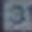

In [53]:
svhn[150][0]

In [54]:
svhn[150][1]

3

In [80]:
transform1 = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [81]:
svhn = datasets.SVHN(root=svhn_path, download=True, transform=transform1)

Using downloaded and verified file: ./data/svhn/train_32x32.mat


In [82]:
svhn

Dataset SVHN
    Number of datapoints: 73257
    Root location: ./data/svhn
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [83]:
mnist = datasets.MNIST(root=mnist_path, download=True, transform=transform2)

In [84]:
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

## DataLoader

In [89]:
batch_size = 64

In [90]:
import torch.utils.data

svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=8)

mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=8)

In [91]:
batch = iter(svhn_loader).next()
print(batch[0].shape)
print(batch[1].shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [92]:
batch = iter(mnist_loader).next()
print(batch[0].shape)
print(batch[1].shape)

torch.Size([64, 1, 32, 32])
torch.Size([64])


## Model

In [101]:
import torch.nn as nn
import torch.nn.functional as F

In [104]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [95]:
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)


def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

### Generator

In [107]:
class G12(nn.Module):
    """Generator for transfering from mnist to svhn"""
    def __init__(self, conv_dim=64):
        super(G12, self).__init__()
        
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        
        self.conv3 = conv(conv_dim * 2, conv_dim * 2, 3, 1, 1)
        self.conv4 = conv(conv_dim * 2, conv_dim * 2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim * 2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, bn=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.conv3(out), 0.05)    # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv4(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        
        return out

In [108]:
class G21(nn.Module):
    """Generator for transfering from svhn to mnist"""
    def __init__(self, conv_dim=64):
        super(G21, self).__init__()
        
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        
        self.conv3 = conv(conv_dim * 2, conv_dim * 2, 3, 1, 1)
        self.conv4 = conv(conv_dim * 2, conv_dim * 2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim * 2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, bn=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.conv3(out), 0.05)    # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv4(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 1, 32, 32)
        
        return out

In [109]:
!pip install torchsummary

In [110]:
from torchsummary import summary
model = G12().to(device)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,024
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3            [-1, 128, 8, 8]         131,072
       BatchNorm2d-4            [-1, 128, 8, 8]             256
            Conv2d-5            [-1, 128, 8, 8]         147,456
       BatchNorm2d-6            [-1, 128, 8, 8]             256
            Conv2d-7            [-1, 128, 8, 8]         147,456
       BatchNorm2d-8            [-1, 128, 8, 8]             256
   ConvTranspose2d-9           [-1, 64, 16, 16]         131,072
      BatchNorm2d-10           [-1, 64, 16, 16]             128
  ConvTranspose2d-11            [-1, 3, 32, 32]           3,072
Total params: 562,176
Trainable params: 562,176
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [111]:
from torchsummary import summary
model = G21().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,072
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3            [-1, 128, 8, 8]         131,072
       BatchNorm2d-4            [-1, 128, 8, 8]             256
            Conv2d-5            [-1, 128, 8, 8]         147,456
       BatchNorm2d-6            [-1, 128, 8, 8]             256
            Conv2d-7            [-1, 128, 8, 8]         147,456
       BatchNorm2d-8            [-1, 128, 8, 8]             256
   ConvTranspose2d-9           [-1, 64, 16, 16]         131,072
      BatchNorm2d-10           [-1, 64, 16, 16]             128
  ConvTranspose2d-11            [-1, 1, 32, 32]           1,024
Total params: 562,176
Trainable params: 562,176
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

### Discriminator

In [120]:
class D1(nn.Module):
    """Discriminator for mnist"""
    def __init__(self, conv_dim=64):
        super(D1, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)        
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        self.fc = conv(conv_dim * 4, 1, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)
        out = F.leaky_relu(self.conv2(out), 0.05)        
        out = F.leaky_relu(self.conv3(out), 0.05)        
        out = self.fc(out).squeeze()
        return out

In [121]:
from torchsummary import summary
model = D1().to(device)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,024
            Conv2d-2            [-1, 128, 8, 8]         131,072
       BatchNorm2d-3            [-1, 128, 8, 8]             256
            Conv2d-4            [-1, 256, 4, 4]         524,288
       BatchNorm2d-5            [-1, 256, 4, 4]             512
            Conv2d-6              [-1, 1, 1, 1]           4,096
Total params: 661,248
Trainable params: 661,248
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 2.52
Estimated Total Size (MB): 2.84
----------------------------------------------------------------


In [123]:
class D2(nn.Module):
    """Discriminator for svhn"""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D2, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)        
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        self.fc = conv(conv_dim * 4, 1, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)
        out = F.leaky_relu(self.conv2(out), 0.05)        
        out = F.leaky_relu(self.conv3(out), 0.05)        
        out = self.fc(out).squeeze()
        return out

In [124]:
from torchsummary import summary
model = D2().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,072
            Conv2d-2            [-1, 128, 8, 8]         131,072
       BatchNorm2d-3            [-1, 128, 8, 8]             256
            Conv2d-4            [-1, 256, 4, 4]         524,288
       BatchNorm2d-5            [-1, 256, 4, 4]             512
            Conv2d-6              [-1, 1, 1, 1]           4,096
Total params: 663,296
Trainable params: 663,296
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.31
Params size (MB): 2.53
Estimated Total Size (MB): 2.85
----------------------------------------------------------------


### CycleGAN

In [147]:
g12 = G12(conv_dim=64).to(device)
g21 = G21(conv_dim=64).to(device)
d1 = D1(conv_dim=64).to(device)
d2 = D2(conv_dim=64).to(device)

In [148]:
g_params = list(g12.parameters()) + list(g21.parameters())
d_params = list(d1.parameters()) + list(d2.parameters())

In [149]:
import torch.optim as optim

g_optimizer = optim.Adam(g_params, 1e-4, [0.5, 0.999])
d_optimizer = optim.Adam(d_params, 1e-4, [0.5, 0.999])

## Training

In [155]:
svhn_iter = iter(svhn_loader)
mnist_iter = iter(mnist_loader)

In [156]:
len(svhn_iter), len(mnist_iter)

(1145, 938)

In [157]:
iter_per_epoch = min(len(svhn_iter), len(mnist_iter))
iter_per_epoch

938

In [158]:
def reset_grad():
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

In [159]:
train_iters = 40000
log_step = 100

d_real_losses = []
d_fake_losses = []
g1_losses = []
g2_losses = []

for step in range(1, train_iters + 1):
    # reset data_iter for epoch
    if step % iter_per_epoch == 0:
        mnist_iter = iter(mnist_loader)
        svhn_iter = iter(svhn_loader)
    
    svhn, s_labels = svhn_iter.next()
    mnist, m_labels = mnist_iter.next()
    svhn, s_labels = svhn.to(device), s_labels.to(device)
    mnist, m_labels = mnist.to(device), m_labels.to(device)
    
    # train discriminator
    reset_grad()
    
    # real画像で訓練
    # real画像なのでtargetは1
    out = d1(mnist)
    d1_loss = torch.mean((out - 1) ** 2)
    
    out = d2(svhn)
    d2_loss = torch.mean((out - 1) ** 2)
    
    d_real_loss = d1_loss + d2_loss
    d_real_losses.append(d_real_loss.item())
    d_real_loss.backward()
    d_optimizer.step()
    
    # generatorで生成したfake画像で訓練
    # fake画像なのでtargetは0
    reset_grad()

    fake_svhn = g12(mnist)
    out = d2(fake_svhn)
    d2_loss = torch.mean(out ** 2)
    
    fake_mnist = g21(svhn)
    out = d1(fake_mnist)
    d1_loss = torch.mean(out ** 2)
    
    d_fake_loss = d1_loss + d2_loss
    d_fake_losses.append(d_fake_loss.item())
    d_fake_loss.backward()
    d_optimizer.step()
    
    # train generator
    reset_grad()
    
    # mnist => svhn => mnistのサイクル
    fake_svhn = g12(mnist)
    out = d2(fake_svhn)

    # gはdを騙したいのでfakeを1に近づけたい
    g1_loss = torch.mean((out - 1) ** 2)
    
    reconst_mnist = g21(fake_svhn)
    g1_loss += torch.mean((mnist - reconst_mnist) ** 2)
    g1_losses.append(g1_loss.item())
    g1_loss.backward()
    g_optimizer.step()
    
    # svhn => mnist => svhnのサイクル
    reset_grad()
    fake_mnist = g21(svhn)
    out = d1(fake_mnist)
    g2_loss = torch.mean((out - 1) ** 2)
    
    reconst_svhn = g12(fake_mnist)
    g2_loss += torch.mean((svhn - reconst_svhn) ** 2)
    g2_losses.append(g2_loss.item())
    g2_loss.backward()
    g_optimizer.step()
    
    if step % log_step == 0:
        print(f'Step [{step}/{train_iters}], d_real_loss: {d_real_loss.item()}, d_fake_loss: {d_fake_loss.item()}, g1_loss: {g1_loss.item()}, g2_loss: {g2_loss.item()}')
    
    if step % 5000 == 0:
        torch.save(g12.state_dict(), f'g12-{step}.pkl')
        torch.save(g12.state_dict(), f'g12-{step}.pkl')
        torch.save(d1.state_dict(), f'd1-{step}.pkl')
        torch.save(d2.state_dict(), f'd2-{step}.pkl')                

Step [100/40000], d_real_loss: 0.11025290191173553, d_fake_loss: 0.03772391006350517, g1_loss: 1.0897891521453857, g2_loss: 1.294374942779541
Step [200/40000], d_real_loss: 0.0980357825756073, d_fake_loss: 0.08165669441223145, g1_loss: 1.13115394115448, g2_loss: 1.476405143737793
Step [300/40000], d_real_loss: 0.09316019713878632, d_fake_loss: 0.09732900559902191, g1_loss: 1.283158540725708, g2_loss: 1.0786025524139404
Step [400/40000], d_real_loss: 0.048470474779605865, d_fake_loss: 0.5071689486503601, g1_loss: 1.8001788854599, g2_loss: 1.1459002494812012
Step [500/40000], d_real_loss: 0.08308134973049164, d_fake_loss: 0.07499479502439499, g1_loss: 0.901957094669342, g2_loss: 1.180112600326538
Step [600/40000], d_real_loss: 0.042414940893650055, d_fake_loss: 0.16951331496238708, g1_loss: 1.5781599283218384, g2_loss: 1.3792873620986938
Step [700/40000], d_real_loss: 0.1734279990196228, d_fake_loss: 0.0837896317243576, g1_loss: 1.0996662378311157, g2_loss: 1.0498077869415283
Step [800/4

## Evaluation

In [160]:
len(d_real_losses), len(d_fake_losses), len(g1_losses), len(g2_losses)

(40000, 40000, 40000, 40000)

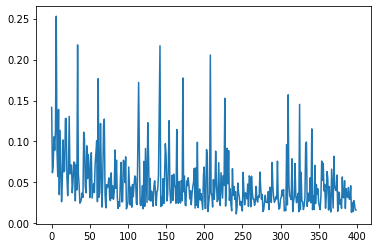

In [168]:
plt.plot(d_real_losses[::100])

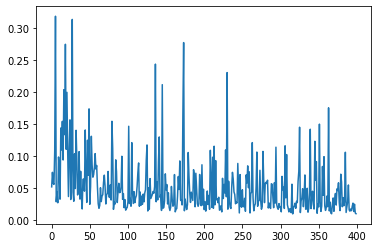

In [169]:
plt.plot(d_fake_losses[::100])

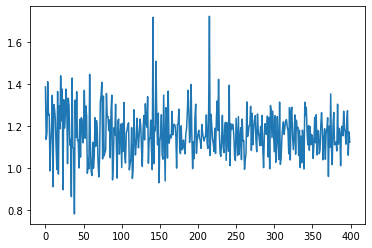

In [171]:
plt.plot(g2_losses[::100])

In [178]:
fixed_svhn = svhn_iter.next()[0].to(device)
fixed_svhn.shape

torch.Size([64, 3, 32, 32])

In [179]:
fixed_mnist = mnist_iter.next()[0].to(device)
fixed_mnist.shape

torch.Size([64, 1, 32, 32])

In [208]:
# converted images
fake_svhn = g12(fixed_mnist)
fake_mnist = g21(fixed_svhn)

In [209]:
fake_svhn.shape

torch.Size([64, 3, 32, 32])

In [210]:
fake_mnist.shape

torch.Size([64, 1, 32, 32])

In [211]:
import numpy as np

def merge_images(sources, targets, k=10):
    _, _, h, w = sources.shape
    row = int(np.sqrt(64))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged.transpose(1, 2, 0)

In [206]:
!pip install imageio

     |████████████████████████████████| 3.3MB 7.6MB/s eta 0:00:01


In [212]:
import imageio

mnist_images = merge_images(fixed_mnist.cpu().detach().numpy(), fake_svhn.cpu().detach().numpy())
imageio.imwrite('mnist_images.png', mnist_images)

Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


In [213]:
svhn_images = merge_images(fixed_svhn.cpu().detach().numpy(), fake_mnist.cpu().detach().numpy())
imageio.imwrite('svhn_images.png', svhn_images)

Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
